<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' alt="SUT logo" width=300 height=300 align=center class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
Modeling Robot Navigation Using Bayesian Network  <br>


# Libraries

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

# Q1: Modeling Robot Navigation Using Bayesian Network  (100 Points)

# Introduction

In this assignment, we will explore the implementation of Bayesian networks to facilitate robotic navigation in an uncertain environment. A Bayesian network offers a graphical model that allows us to represent and reason about the dependencies among various uncertain variables. By leveraging the power of probabilistic reasoning, we can help a robot make informed decisions regarding its movements based on observations of external factors, such as weather conditions, battery levels, and obstacle presence.

The primary objective of this assignment is to construct a Bayesian network that models the navigation scenario, encompassing key variables that impact the robot's movement. We will implement Conditional Probability Distributions (CPDs) to define the probabilistic relationships among these variables and utilize the variable elimination algorithm to perform inference in the network. Through this process, we aim to calculate the most likely robot position given specific evidence.

# Factors and Their Relationships

In our Bayesian network, we define several critical factors that influence the robot's navigation decisions. Each factor represents a variable that carries uncertainty and plays a significant role in determining the robot's movement strategy. The key factors in our model include:

1. Weather: The weather conditions affect the performance and accuracy of the robot's sensors. Possible states include "clear," "rain," and "fog."

2. Battery Level: This variable indicates the robot's remaining energy. It can be classified as "high" or "low," impacting the likelihood of successful movement.

3. Goal Distance: This factor measures the proximity of the robot to its target destination. It is categorized as "near" or "far," which influences the robot's navigation strategy.

4. Sensor Accuracy: Dependent on the weather conditions, this variable determines how reliable the robot's sensors are in detecting obstacles. It can be either "high" or "low."

5. Obstacle Detection: Based on sensor accuracy, this variable indicates whether an obstacle is detected in the robot's path. The states are "obstacle" or "no_obstacle."

6. Move Success: This factor is influenced by the battery level and determines whether the robot can successfully move in its intended direction. It can be "success" or "failure."

7. Robot Position: The robot's moving position in the grid, which is influenced by move success, obstacle detection, and goal distance.

The relationships among these factors are captured through directed edges in the Bayesian network. For instance, the sensor accuracy is influenced by the weather, while obstacle detection relies on sensor accuracy. Moreover, move success depends on the battery level, and the robot's position is contingent on both move success and obstacle detection. These dependencies enable us to calculate joint probabilities and perform inference using the network.

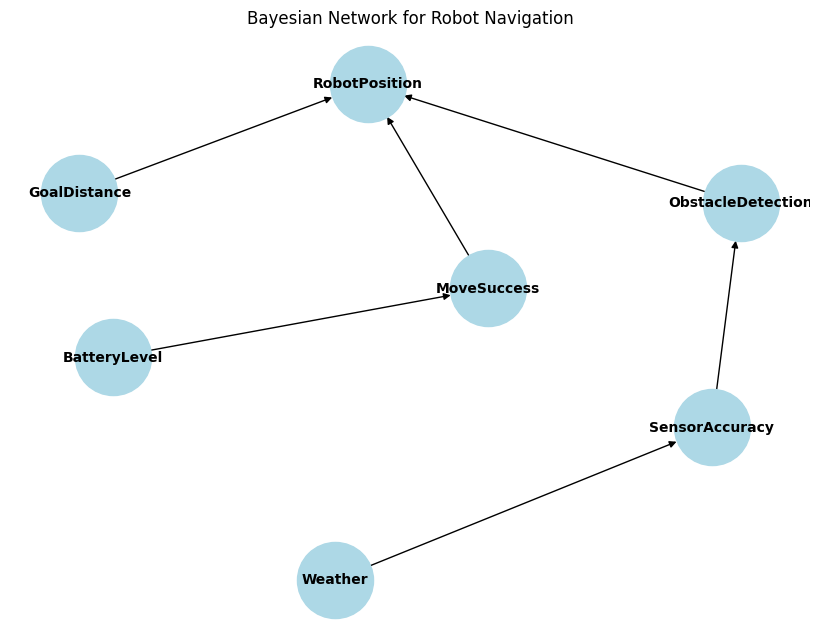

In [4]:
G = nx.DiGraph()
G.add_edges_from([
    ('Weather', 'SensorAccuracy'),
    ('BatteryLevel', 'MoveSuccess'),
    ('SensorAccuracy', 'ObstacleDetection'),
    ('ObstacleDetection', 'RobotPosition'),
    ('GoalDistance', 'RobotPosition'),
    ('MoveSuccess', 'RobotPosition')
])


pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight='bold')
plt.title('Bayesian Network for Robot Navigation')
plt.show()


# Implementing CPDs and Variable Elimination (50 points)

The implementation of Conditional Probability Distributions (CPDs) is crucial for representing the probabilistic relationships between variables in our Bayesian network. Each CPD defines a probability distribution for a variable based on its parent variables, capturing the uncertainties inherent in the system.

In this assignment, we will also implement the variable elimination algorithm, a widely used technique for exact inference in Bayesian networks. This algorithm allows us to compute the posterior probabilities of query variables, such as the robot's position, given certain observed evidence, such as current weather conditions and battery levels.

The variable elimination process consists of several steps:

1. Restrict CPDs based on observed evidence: This involves limiting the CPDs to the subset of variable assignments consistent with the observed values.
2. Eliminate irrelevant variables: Variables not involved in the query or evidence are summed out to simplify the network.
3. Multiply remaining CPDs: After eliminating variables, the remaining CPDs are combined to form a new joint distribution.
4. Normalize the result: The final step ensures that the resulting probabilities sum to one, providing a valid probability distribution for the queried variable.

In [5]:
class CPD:
    def __init__(self, variables, probabilities):
        """
        Factor table for a set of variables.
        :param variables: A list of variables involved in the factor.
        :param probabilities: A dictionary mapping variable assignments (tuples) to probabilities.
        """
        self.variables = variables
        self.probabilities = probabilities

    def restrict(self, variable, value):
        if variable not in self.variables:
            raise ValueError(f"Variable '{variable}' not found in CPD for {self.variables}")
        index = self.variables.index(variable)
        new_variables = [v for v in self.variables if v != variable]
        new_probabilities = {
            tuple(assignment[:index] + assignment[index + 1:]): prob
            for assignment, prob in self.probabilities.items()
            if assignment[index] == value
        }
        return CPD(new_variables, new_probabilities)

    def sum_out(self, variable):
        index = self.variables.index(variable)
        new_variables = [v for v in self.variables if v != variable]
        new_probabilities = {}
        for assignment, prob in self.probabilities.items():
            reduced_assignment = tuple(assignment[:index] + assignment[index + 1:])
            new_probabilities[reduced_assignment] = new_probabilities.get(reduced_assignment, 0) + prob
        return CPD(new_variables, new_probabilities)

    def multiply(self, other):
        shared_variables = set(self.variables) & set(other.variables)
        all_variables = list(self.variables) + [v for v in other.variables if v not in self.variables]

        new_probabilities = {}
        for self_assignment, self_prob in self.probabilities.items():
            for other_assignment, other_prob in other.probabilities.items():
                if all(self_assignment[self.variables.index(var)] == other_assignment[other.variables.index(var)]
                       for var in shared_variables):
                    combined_assignment = tuple(
                        self_assignment[self.variables.index(var)] if var in self.variables else
                        other_assignment[other.variables.index(var)]
                        for var in all_variables
                    )
                    new_probabilities[combined_assignment] = new_probabilities.get(combined_assignment, 0) + self_prob * other_prob
        return CPD(all_variables, new_probabilities)

    def normalize(self):
        sum_of_prob = sum(self.probabilities.values())
        if sum_of_prob == 0:
            raise ValueError("Sum of probabilities is zero. Cannot normalize.")
        new_probabilities = {assignment: prob / sum_of_prob for assignment, prob in self.probabilities.items()}
        return CPD(self.variables, new_probabilities)

In [6]:
def variable_elimination(cpds, query_vars, evidence):
    """
    Perform inference using variable elimination.
    :param cpds: A list of CPD objects representing the Bayesian network.
    :param query_vars: A list of query variables.
    :param evidence: A dictionary of observed evidence variables and their values.
    :return: A normalized CPD representing the posterior distribution.
    """

    # Step 1: Restrict CPDs based on the provided evidence
    adjusted_cpds = []
    for factor in cpds:
        for ev_var, ev_val in evidence.items():
            if ev_var in factor.variables:
                factor = factor.restrict(ev_var, ev_val)
        adjusted_cpds.append(factor)

    # Step 2: Determine variables to eliminate
    all_variables = set(var for factor in adjusted_cpds for var in factor.variables)
    elimination_vars = all_variables - set(query_vars) - set(evidence.keys())

    # Step 3: Eliminate variables iteratively
    for elim_var in elimination_vars:
        relevant_factors = [factor for factor in adjusted_cpds if elim_var in factor.variables]

        combined_factor = relevant_factors[0]
        for next_factor in relevant_factors[1:]:
            combined_factor = combined_factor.multiply(next_factor)

        marginalized_factor = combined_factor.sum_out(elim_var)
        
        adjusted_cpds = [factor for factor in adjusted_cpds if factor not in relevant_factors]
        adjusted_cpds.append(marginalized_factor)

    # Step 4: Combine remaining factors to compute the result
    result_factor = adjusted_cpds[0]
    for other_factor in adjusted_cpds[1:]:
        result_factor = result_factor.multiply(other_factor)

    # Step 5: Normalize the resulting factor
    return result_factor.normalize()


In [7]:
# Example usage:
cpds = [
    CPD(["A"], {('a',): 0.6, ('b',): 0.4}),
    CPD(["A", "B"], {('a', 0): 0.7, ('a', 1): 0.3, ('b', 0): 0.2, ('b', 1): 0.8}),
    CPD(["B", "C"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
    CPD(["B", "D"], {(0, 0): 0.9, (0, 1): 0.1, (1, 0): 0.4, (1, 1): 0.6}),
]

query_vars = ["D"]
evidence = {"A": 'a'}

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting CPD (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")

Resulting CPD (Posterior Distribution):
P(0) = 0.75
P(1) = 0.24999999999999994


# CPD Tables (5 points)

The tables are given to you as png files. you need to create the CPDs and use them for inference.

In [9]:
# CPD generation from the CPDs
cpds = []

# CPD for 'Weather' (single variable)
weather_cpd = CPD(
    variables=["Weather"],
    probabilities={('Clear',): 0.5,
                   ('Rain',): 0.3,
                   ('Fog',):0.2}
)
cpds.append(weather_cpd)

# CPD for 'BatteryLevel' (single variable)
battery_level_cpd = CPD(
    variables=["BatteryLevel"],
    probabilities={('High',): 0.7,
                   ('Low',): 0.3}
)
cpds.append(battery_level_cpd)

# CPD for 'GoalDistance' (single variable)
goal_distance_cpd = goal_distance_cpd = CPD(
    variables=["GoalDistance"],
    probabilities={('Near',): 0.4,
                   ('Far',): 0.6}
)
cpds.append(goal_distance_cpd)

# CPD for 'SensorAccuracy' (dependent on 'Weather')
sensor_accuracy_cpd = CPD(
    variables=["Weather", "SensorAccuracy"],
    probabilities={
        ('Clear', 'High'): 0.8,
        ('Clear', 'Low'): 0.2,
        ('Rain', 'High'): 0.4,
        ('Rain', 'Low'): 0.6,
        ('Fog', 'High'): 0.2,
        ('Fog', 'Low'): 0.8
    }
)
cpds.append(sensor_accuracy_cpd)

# CPD for 'ObstacleDetection' (dependent on 'SensorAccuracy')
obstacle_detection_cpd = CPD(
    variables=["SensorAccuracy", "ObstacleDetection"],
    probabilities={
        ('High', 'Obstacle'): 0.7,
        ('High', 'Not Obstacle'): 0.3,
        ('Low', 'Obstacle'): 0.4,
        ('Low', 'Not Obstacle'): 0.6
    }
)
cpds.append(obstacle_detection_cpd)

# CPD for 'MoveSuccess' (dependent on 'BatteryLevel')
move_success_cpd = CPD(
    variables=["BatteryLevel", "MoveSuccess"],
    probabilities={
        ('High', 'Success'): 0.9,
        ('High', 'Failure'): 0.1,
        ('Low', 'Success'): 0.6,
        ('Low', 'Failure'): 0.4
    }
)
cpds.append(move_success_cpd)

# CPD for 'RobotPosition' (dependent on 'MoveSuccess', 'ObstacleDetection', and 'GoalDistance')
robot_position_cpd = CPD(
    variables=["MoveSuccess", "ObstacleDetection", "GoalDistance", "RobotPosition"],
    probabilities={
        ('Success', 'Not Obstacle', 'Near', 'Up'): 0.2,
        ('Success', 'Not Obstacle', 'Near', 'Down'): 0.2,
        ('Success', 'Not Obstacle', 'Near', 'Left'): 0.2,
        ('Success', 'Not Obstacle', 'Near', 'Right'): 0.4,
        
        ('Success', 'Not Obstacle', 'Far', 'Up'): 0.1,
        ('Success', 'Not Obstacle', 'Far', 'Down'): 0.4,
        ('Success', 'Not Obstacle', 'Far', 'Left'): 0.1,
        ('Success', 'Not Obstacle', 'Far', 'Right'): 0.4,
        
        ('Success', 'Obstacle', 'Near', 'Up'): 0.0,
        ('Success', 'Obstacle', 'Near', 'Down'): 0.3,
        ('Success', 'Obstacle', 'Near', 'Left'): 0.1,
        ('Success', 'Obstacle', 'Near', 'Right'): 0.7,
        
        ('Success', 'Obstacle', 'Far', 'Up'): 0.1,
        ('Success', 'Obstacle', 'Far', 'Down'): 0.4,
        ('Success', 'Obstacle', 'Far', 'Left'): 0.3,
        ('Success', 'Obstacle', 'Far', 'Right'): 0.2,
        
        
        ('Failure', 'Not Obstacle', 'Near', 'Up'): 0.2,
        ('Failure', 'Not Obstacle', 'Near', 'Down'): 0.2,
        ('Failure', 'Not Obstacle', 'Near', 'Left'): 0.3,
        ('Failure', 'Not Obstacle', 'Near', 'Right'): 0.3,
        
        ('Failure', 'Not Obstacle', 'Far', 'Up'): 0.1,
        ('Failure', 'Not Obstacle', 'Far', 'Down'): 0.0,
        ('Failure', 'Not Obstacle', 'Far', 'Left'): 0.4,
        ('Failure', 'Not Obstacle', 'Far', 'Right'): 0.4,
        
        ('Failure', 'Obstacle', 'Near', 'Up'): 0.0,
        ('Failure', 'Obstacle', 'Near', 'Down'): 0.3,
        ('Failure', 'Obstacle', 'Near', 'Left'): 0.3,
        ('Failure', 'Obstacle', 'Near', 'Right'): 0.4,
        
        ('Failure', 'Obstacle', 'Far', 'Up'): 0.0,
        ('Failure', 'Obstacle', 'Far', 'Down'): 0.2,
        ('Failure', 'Obstacle', 'Far', 'Left'): 0.25,
        ('Failure', 'Obstacle', 'Far', 'Right'): 0.55
    }
)
cpds.append(robot_position_cpd)

In [11]:
query_vars = ["RobotPosition"]
# evidence = {"Weather": 'clear'}
evidence = {
            'Weather': 'Clear',
            'BatteryLevel': 'Low',
            'GoalDistance': 'Far',
            # 'SensorAccuracy': 'high',
            # 'ObstacleDetection': 'no_obstacle',
            # 'MoveSuccess': 'success'
        }

result = variable_elimination(cpds, query_vars, evidence)
print("Resulting cpd (Posterior Distribution):")
for assignment, prob in result.probabilities.items():
    print(f"P({assignment[0]}) = {prob}")


Resulting cpd (Posterior Distribution):
P(Up) = 0.07548701298701298
P(Down) = 0.2954545454545454
P(Left) = 0.2621753246753247
P(Right) = 0.366883116883117


# Sampling Methods (30 points)

To complement our Bayesian network, we will implement three different sampling methods to estimate the posterior probabilities of the robot's position based on observed evidence:

1. Prior Sampling (10 points): In this method, we will generate samples from the joint distribution defined by the CPDs without conditioning on any evidence. The samples will be used to approximate the distribution of the query variable, such as the robot's position, before any evidence is considered.

In [12]:
def prior_sampling_query(cpds, query, evidence, num_samples=1000):
    """
    Perform Prior Sampling to estimate the probability of a query variable given evidence.
    :param cpds: List of CPD objects representing the conditional probability tables of the Bayesian network.
    :param query: A tuple representing the query variable and its value, e.g., ('MoveSuccess', 'success').
    :param evidence: A dictionary of observed evidence variables and their values, e.g., {'Weather': 'clear'}.
    :param num_samples: The number of samples to generate.
    :return: The estimated probability of the query variable having the specified value given the evidence.
    """
    
    def generate_sample(cpd, sampled_data):
        """
        Generate a sample for a variable based on its CPD and already sampled data.
        :param cpd: The CPD object for the variable being sampled.
        :param sampled_data: A dictionary of previously sampled variables and their values.
        :return: The sampled value for the current variable.
        """
        filtered_cpd = {
            key: prob
            for key, prob in cpd.probabilities.items()
            if all(sampled_data.get(parent_var, None) == parent_val for parent_var, parent_val in zip(cpd.variables[:-1], key[:-1]))
        }

        if not filtered_cpd:
            raise ValueError(
                f"Missing matching entries in CPD for variable '{cpd.variables[-1]}' "
                f"with sampled data: {sampled_data}"
            )
        outcomes, probs = zip(*[(key[-1], prob) for key, prob in filtered_cpd.items()])
        return random.choices(outcomes, probs)[0]

    target_var, target_val = query
    match_count = 0
    evidence_satisfied_count = 0

    for _ in range(num_samples):
        sampled_data = {}
        for cpd in cpds:
            current_var = cpd.variables[-1]
            sampled_data[current_var] = generate_sample(cpd, sampled_data)

        if all(sampled_data.get(ev_var) == ev_val for ev_var, ev_val in evidence.items()):
            evidence_satisfied_count += 1
            if sampled_data.get(target_var) == target_val:
                match_count += 1

    return match_count / evidence_satisfied_count if evidence_satisfied_count > 0 else 0


In [16]:
query = ('RobotPosition', 'Up')
evidence = {'Weather': 'Clear'}
prob_prior = prior_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_prior}')

The estimated probability for moving up is 0.08437562040897359


2. Likelihood Weighting (10 points): This method incorporates evidence into the sampling process by assigning weights to samples based on the likelihood of the observed evidence given the sampled values. This approach allows for more accurate estimation of the posterior probabilities by prioritizing samples that align with the evidence.

In [17]:
def likelihood_weighting_query(cpds, query, evidence, num_samples=1000):
    """
    Perform Likelihood Weighting to estimate the probability of a query variable given evidence.
    :param cpds: List of CPD objects representing the conditional probability tables of the Bayesian network.
    :param query: A tuple representing the query variable and its value, e.g., ('MoveSuccess', 'success').
    :param evidence: A dictionary of observed evidence variables and their values, e.g., {'Weather': 'clear'}.
    :param num_samples: The number of weighted samples to generate.
    :return: The estimated probability of the query variable having the specified value given the evidence.
    """
    weighted_data = []

    for _ in range(num_samples):
        current_sample = {}
        current_weight = 1.0

        for factor in cpds:
            var_name = factor.variables[-1]
            parent_vals = tuple(current_sample[parent] for parent in factor.variables[:-1]) if len(factor.variables) > 1 else ()

            if var_name in evidence:
                observed_value = evidence[var_name]
                probabilities = [prob for key, prob in factor.probabilities.items() if key[:-1] == parent_vals]
                outcomes = [key[-1] for key, prob in factor.probabilities.items() if key[:-1] == parent_vals]

                if observed_value in outcomes:
                    current_weight *= probabilities[outcomes.index(observed_value)]
                else:
                    current_weight = 0
                    break

                current_sample[var_name] = observed_value
            else:
                probabilities = [prob for key, prob in factor.probabilities.items() if key[:-1] == parent_vals]
                outcomes = [key[-1] for key, prob in factor.probabilities.items() if key[:-1] == parent_vals]

                current_sample[var_name] = random.choices(outcomes, probabilities)[0]

        if current_weight > 0:
            weighted_data.append((current_sample, current_weight))

    query_var, query_val = query
    total_weight = sum(wt for _, wt in weighted_data)

    if total_weight == 0:
        return 0

    query_total_weight = sum(wt for sample, wt in weighted_data if sample[query_var] == query_val)
    return query_total_weight / total_weight


In [19]:
query = ('RobotPosition', 'Up')
evidence = {'Weather': 'Clear'}
prob_lw = likelihood_weighting_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_lw}')

The estimated probability for moving up is 0.0804


3. Gibbs Sampling (10 points): This technique is an iterative method that generates samples from the joint distribution by conditioning on the current values of other variables. It allows for efficient sampling, especially in high-dimensional spaces, by focusing on one variable at a time while keeping others fixed.



In [20]:
def gibbs_sampling_query(cpds, query, evidence, num_samples=1000):
    """
    Performs Gibbs sampling to estimate the probability of a query variable given evidence.

    Args:
    - cpds: List of CPD objects representing the Bayesian network.
    - query: A tuple (variable, value) representing the query.
    - evidence: A dictionary {variable: value} representing the observed evidence.
    - num_samples: Number of samples to generate (default: 1000).

    Returns:
    - Estimated probability of the query variable taking the queried value given the evidence.
    """
    all_vars = {v for cpd in cpds for v in cpd.variables}
    variable_states = {v: evidence.get(v, None) for v in all_vars}
    for var in all_vars - evidence.keys():
        linked_cpd = next((cpd for cpd in cpds if cpd.variables[-1] == var), None)
        if not linked_cpd:
            raise RuntimeError(f"Missing CPD for variable '{var}'.")
        possible_outcomes = {entry[-1] for entry in linked_cpd.probabilities.keys()}
        variable_states[var] = random.choice(list(possible_outcomes))

    cpd_map = {cpd.variables[-1]: cpd for cpd in cpds}
    query_var, target_value = query
    matching_samples = 0
    effective_samples = 0

    for idx in range(num_samples + 100):
        for current_var in all_vars:
            if current_var not in evidence:
                associated_cpd = cpd_map.get(current_var)
                if not associated_cpd:
                    raise RuntimeError(f"No CPD for variable '{current_var}'.")
                
                parents = associated_cpd.variables[:-1]
                parent_state = tuple(variable_states[p] for p in parents)
                filtered_probs = {
                    outcome[-1]: prob
                    for outcome, prob in associated_cpd.probabilities.items()
                    if outcome[:-1] == parent_state
                }
                prob_sum = sum(filtered_probs.values())
                if prob_sum == 0:
                    raise RuntimeError(f"Total probability for '{current_var}' is zero under {parent_state}.")
                normalized_probs = {val: prob / prob_sum for val, prob in filtered_probs.items()}
                variable_states[current_var] = random.choices(
                    list(normalized_probs.keys()),
                    weights=normalized_probs.values(),
                    k=1,
                )[0]

        if idx >= 100 and (idx - 100) % 10 == 0: 
            if variable_states[query_var] == target_value:
                matching_samples += 1
            effective_samples += 1

    return matching_samples / effective_samples if effective_samples > 0 else 0.0



In [22]:
query = ('RobotPosition', 'Up')
evidence = {'Weather': 'Clear'}
prob_gibbs = gibbs_sampling_query(cpds, query, evidence, num_samples=10000)
print(f'The estimated probability for moving up is {prob_gibbs}')

The estimated probability for moving up is 0.086


# Robot Movement and Inference Methods (15 points)
In this assignment, we have implemented a robot navigation system that utilizes Bayesian networks to make informed decisions about its movement within a grid. The robot begins at the position
(0,0) and aims to reach the goal located at the opposite corner of the grid, while navigating potential obstacles and managing its battery level.

To determine the most likely direction the robot should move at each step, we employ various inference methods from Bayesian statistics. The robot’s movement decisions rely on the current state, which includes environmental factors such as weather conditions, battery level, distance to the goal, sensor accuracy, and obstacle detection.

run the following code to check you implementation.

In [ ]:
class RobotNavigation:
    def __init__(self, grid_size=5, cpds=None, obstacles=None):
        self.grid_size = grid_size
        self.robot_position = (0, 0)  # Starting position at top-left corner
        self.goal_position = (grid_size-1, grid_size-1)  # Goal is at the bottom-right corner
        self.cpds = cpds  # Conditional probability distributions (CPDs)
        # Obstacles placed at specific positions (not randomly, to be defined)
        self.obstacles = obstacles if obstacles else [(2, 2), (1, 3)]
        self.battery_level = 10
        self.state = {
            'Weather': 'clear',
            'BatteryLevel': 'high',
            'GoalDistance': 'far',
            'SensorAccuracy': 'high',
            'ObstacleDetection': 'no_obstacle',
            'MoveSuccess': 'success'
        }

    def move_robot(self, factors, method):
        # Update state with any specific factors provided (like {'Weather': 'clear'})
        self.state.update(factors)

        query_vars = ['RobotPosition']
        evidence = self.state  # Current state is the evidence

        # Choose the inference method
        if method == 'exact_inference':
            result = variable_elimination(self.cpds, query_vars, evidence).probabilities
        elif method == 'prior':
            result = {direction: prior_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'likelihood':
            result = {direction: likelihood_weighting_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}
        elif method == 'gibbs':
            result = {direction: gibbs_sampling_query(self.cpds, ('RobotPosition', direction), evidence)
                      for direction in ['up', 'down', 'left', 'right']}

        # Find the most probable move
        best_move = max(result, key=result.get)
        if method == 'exact_inference': best_move = best_move[0]

        # Move the robot if possible (no obstacle in the way)
        new_position = self.get_new_position(best_move)
        if new_position not in self.obstacles and self.is_within_grid(new_position):
            self.robot_position = new_position

        # Visualize the current state of the grid
        self.visualize_grid()

        # Update the state after moving
        self.update_state(factors)

    def update_state(self, factors):
        self.state = factors
        # Update state, for example, if GoalDistance is near or an obstacle is detected
        distance_to_goal = abs(self.robot_position[0] - self.goal_position[0]) + \
                           abs(self.robot_position[1] - self.goal_position[1])
        self.state['GoalDistance'] = 'near' if distance_to_goal <= 1 else 'far'


        # Decrease battery level with each move
        self.battery_level = max(0, self.battery_level-1)

        # If battery level drops below threshold, update state
        if self.battery_level <= 5:
            self.state['BatteryLevel'] = 'low'

        # # Simulate obstacle detection based on the robot's position
        # self.state['ObstacleDetection'] = 'obstacle' if self.robot_position in self.obstacles else 'no_obstacle'

    def visualize_grid(self):
        grid = [[' ' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        grid[self.goal_position[0]][self.goal_position[1]] = 'G'  # Mark the goal
        grid[self.robot_position[0]][self.robot_position[1]] = 'R'  # Mark the robot
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = 'X'  # Mark obstacles
        for row in grid:
            print(' '.join(row))
        print('\n')

    def get_new_position(self, move):
        """Return the new position of the robot based on the direction of the move."""
        x, y = self.robot_position
        if move == 'up':
            return (x-1, y)
        elif move == 'down':
            return (x+1, y)
        elif move == 'left':
            return (x, y-1)
        elif move == 'right':
            return (x, y+1)

    def is_within_grid(self, position):
        """Check if the new position is within the grid bounds."""
        x, y = position
        return 0 <= x < self.grid_size and 0 <= y < self.grid_size


In [ ]:
# Create an instance of RobotNavigation
robot = RobotNavigation(grid_size=5, cpds=cpds, obstacles=[(2, 2), (1, 3)])

# Continue moving the robot until it reaches the goal
step = 0
while robot.robot_position != robot.goal_position:
    print(f"Robot's current position: {robot.robot_position}")
    # Move the robot using the 'exact_inference' method as an example
    robot.move_robot(factors={'Weather': 'rain'}, method='exact_inference')
    step+=1

print(f"Robot has reached the goal in {step} steps!")


Robot's current position: (0, 0)
         
R     X  
    X    
         
        G


Robot's current position: (1, 0)
         
      X  
R   X    
         
        G


Robot's current position: (2, 0)
         
      X  
    X    
R        
        G


Robot's current position: (3, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
R       G


Robot's current position: (4, 0)
         
      X  
    X    
         
  R     G


Robot's current position: (4, 1)
         
      X  
    X    
         
    R   G


Robot's current position: (4, 2)
         
      X  
    X    
         
      R G


Robot's current position: (4, 3)
         
      X  
    X    
         
        R


Robot has reached the goal in 9 steps!
